In [17]:
from transformers import (GPT2LMHeadModel, GPT2TokenizerFast,
                          BertForMaskedLM, BertTokenizerFast,
                          DistilBertForMaskedLM, DistilBertTokenizerFast,
                          RobertaForMaskedLM, RobertaTokenizerFast,
                          BlenderbotForCausalLM, BlenderbotTokenizer,
                          BigBirdForMaskedLM, BigBirdTokenizer,
                          ElectraForMaskedLM, ElectraTokenizerFast)
from multiprocessing import Pool
import pandas as pd
import glob
from itertools import product, combinations
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from lmeval.datasets import NarrativesDataset, NeuroscoutDataset
from lmeval.engine import StridingForwardLM

In [81]:
### TO DOS:
# Implement pliers extractor
# Run sample models

## Read in data and plot

In [297]:
logs = glob.glob('outputs/narratives/*')

0 of 374
100 of 374
200 of 374
300 of 374


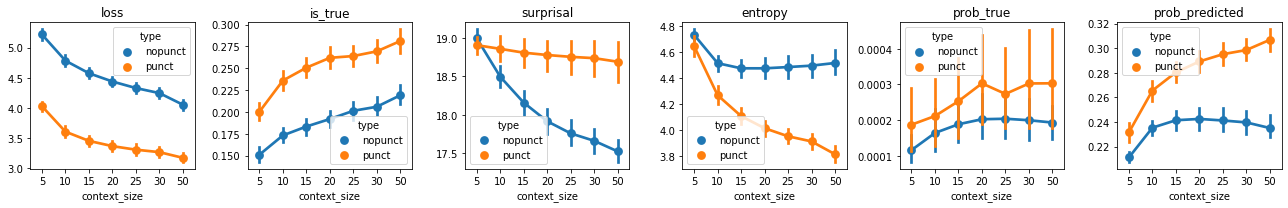

In [288]:
for i, l in enumerate(logs):
    ldf = pd.read_csv(l, sep='\t', index_col=0)
    if i % 100 == 0:
        print(f'{i} of {len(logs)}')
    if l == logs[0]:
        all_logs = ldf
    else:
        all_logs = pd.concat([all_logs, 
                              ldf], ignore_index=True)
all_logs['is_true'] = (all_logs['target'] == all_logs['top_predicted']).astype(int)
all_logs['surprisal'] = -np.log2(all_logs['prob_true'])
all_logs = all_logs.replace({'aligned': 'nopunct', 'transcript':'punct'})
metrics = ['loss', 'is_true', 'surprisal', 'entropy', 'prob_true', 'prob_predicted']
aggs = all_logs.groupby(['type', 'model', 'context_size', 'dataset'])[metrics].mean().reset_index()
fig, ax = plt.subplots(ncols=6, figsize=(18,3))
for i, m in enumerate(metrics):
    sns.pointplot(data=aggs, 
                  x='context_size', 
                  y=m, 
                  hue='type', 
                  ax=ax[i])
    ax[i].set_title(m)
    ax[i].set_ylabel('')
    #ax[i].set_xticklabels(labels=np.arange(0,35,5), rotation=90)
plt.tight_layout()
plt.show()

In [300]:
lcs = [l for l in logs if '_cs' in l]
lnocs = [l for l in logs if '_nocs' in l and 'transcript' not in l]

In [339]:
for i, l in enumerate(lcs):
    ldf = pd.read_csv(l, sep='\t', index_col=0)
    if i == 0:
        all_logs = ldf
    else:
        all_logs = pd.concat([all_logs, 
                              ldf], ignore_index=True)
all_logs['is_true'] = (all_logs['target'] == all_logs['top_predicted']).astype(int)
all_logs['surprisal'] = -np.log2(all_logs['prob_true'])
all_logs = all_logs.replace({'aligned': 'nopunct', 'transcript':'punct'})
metrics = ['loss', 'is_true', 'surprisal', 'entropy', 'prob_true', 'prob_predicted']
aggs = all_logs.groupby(['type', 'model', 'context_size', 'dataset'])[metrics].mean().reset_index()

Correlations between aligned and transcripts

0 of 14


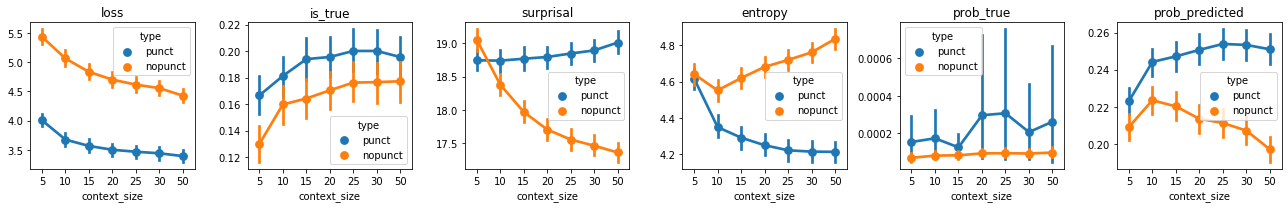

In [282]:
# replace end-up with end up
# replace tiny food with food
logs = glob.glob('outputs/sherlock/*')
for i, l in enumerate(logs):
    ldf = pd.read_csv(l, sep='\t', index_col=0)
    if i % 100 == 0:
        print(f'{i} of {len(logs)}')
    if l == logs[0]:
        all_logs_sherlock = ldf
    else:
        all_logs_sherlock = pd.concat([all_logs_sherlock, 
                              ldf], ignore_index=True)
all_logs_sherlock['is_true'] = (all_logs_sherlock['target'] == all_logs_sherlock['top_predicted']).astype(int)
all_logs_sherlock['surprisal'] = -np.log2(all_logs_sherlock['prob_true'])
all_logs_sherlock = all_logs_sherlock.replace({'aligned': 'nopunct', 'transcript':'punct'})
metrics = ['loss', 'is_true', 'surprisal', 'entropy', 'prob_true', 'prob_predicted']
fig, ax = plt.subplots(ncols=6, figsize=(18,3))
for i, m in enumerate(metrics):
    sns.pointplot(data=all_logs_sherlock, 
                  x='context_size', 
                  y=m, 
                  hue='type', 
                  ax=ax[i])
    #if i != 4:
    #    ax[i].legend('')
    #else:
    #    ax[i].legend(title='')
    ax[i].set_title(m)
    ax[i].set_ylabel('')
    #ax[i].set_xticklabels(labels=np.arange(0,35,5), rotation=90)
plt.tight_layout()
plt.show()